In [54]:
# Dataframe 
import pandas as pd
import numpy as np
import math

# Cleaning 
import re
import redditcleaner
from nltk.corpus import stopwords

# Analysis 
import nltk
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('omw-1.4')
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Sklearn for topic modeling 
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from gensim.utils import simple_preprocess
import en_core_web_sm

# Graph
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Remove Warning 
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/levinadong/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/levinadong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/levinadong/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load the data

In [2]:
#df = pd.read_csv('nbs.csv')
df = pd.read_csv('nba_text.csv')

In [3]:
df.head()

,Post ID,Title,Url,Author,Score,Publish Date,Total No. of Comments,Permalink
0,ttekt0,[Conti] Trae Young will start the third quarter.,https://twitter.com/mikeconti929/status/150969...,OO17MVP,1,3/31/22 18:06,0,/r/nba/comments/ttekt0/conti_trae_young_will_s...
1,tten92,Embiid with the ridiculous eurostep into poste...,https://streamable.com/v6rtdi,maacaack,1,3/31/22 18:10,0,/r/nba/comments/tten92/embiid_with_the_ridicul...
2,tteo2g,Caruso has scored 7 total points in the last 1...,https://www.reddit.com/r/nba/comments/tteo2g/c...,EH15,1,3/31/22 18:11,0,/r/nba/comments/tteo2g/caruso_has_scored_7_tot...
3,tteoul,[Highlight] Embiid with the eurostep into post...,https://streamable.com/v6rtdi,maacaack,1,3/31/22 18:12,0,/r/nba/comments/tteoul/highlight_embiid_with_t...
4,tteqng,[Highlight] Crazy sequence leads to a Jrue Hol...,https://streamable.com/jjxldp,SpeedMalibu,1,3/31/22 18:15,1,/r/nba/comments/tteqng/highlight_crazy_sequenc...


## Clean the data

In [4]:
def cleaning_text(column):
    """
    clean the text column
    """
    #Removing stop words
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    df['clean_text'] = df[column].map(lambda x: re.sub(pattern, '', str(x)))
    df['clean_text'] = df['clean_text'].map(redditcleaner.clean)                     #redditclean
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('nan', '', str(x)))          #Removing nan
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('[\n]', '', str(x)))         #Removing new line tabs
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('[,\.*!?/u/]', '', str(x)))  # Remove punctuation
    df['clean_text'] = df['clean_text'].map(lambda x: x.lower())                     # Convert the titles to lowercase
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r'[^\w]', ' ', str(x)))      # Remove all symbols
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r'[0-9]+', '', str(x)))      # Remove all numerical varibles
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub("\s\s+" , " ", str(x)))      # Remove two space
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r'\s+', ' ', str(x)))        # Remove one space
    df['clean_text'] = df['clean_text'].map(lambda x: str(x).lstrip(' '))                 # Remove whitespace at beginning
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r'\b\w{1,3}\b', '', str(x))) # Remove words length less than 3
    # Remove duplicate phrase
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', str(x), flags = re.I))
    # Others 
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('________', '', str(x)))          
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('_________', '', str(x)))
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('____________', '', str(x)))
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('_qqmjvltldhyiy', '', str(x)))
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('_', '', str(x)))
    # Remove space again
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r"^\s+","", str(x)))
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r"\s+$", "", str(x)))
    
    return df

In [5]:
text = cleaning_text('Title')['clean_text']
text.head()

0                 conti trae yong start third qarter
1                     embiid ridiclos erostep poster
2             carso scored total points last qarters
3                    highlight embiid erostep poster
4    highlight crazy seqence leads  holiday  giannis
Name: clean_text, dtype: object

## Labeling the title 

In [6]:
sia = SIA()
results = []

for line in text:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)
    
results[0]

{'neg': 0.0,
 'neu': 1.0,
 'pos': 0.0,
 'compound': 0.0,
 'headline': 'conti trae yong start third qarter'}

In [7]:
df_title = pd.DataFrame.from_records(results)
df_title.head()

,neg,neu,pos,compound,headline
0,0.000,1.000,0.000,0.0000,conti trae yong start third qarter
1,0.000,1.000,0.000,0.0000,embiid ridiclos erostep poster
2,0.000,1.000,0.000,0.0000,carso scored total points last qarters
3,0.000,0.556,0.444,0.3400,highlight embiid erostep poster
4,0.229,0.286,0.486,0.4019,highlight crazy seqence leads holiday giannis


In [8]:
df_title['label'] = 0
df_title.loc[df_title['compound'] > 0.1, 'label'] = 1
df_title.loc[df_title['compound'] == 0, 'label'] = 0
df_title.loc[df_title['compound'] < -0.1, 'label'] = -1
df_title.head()
#df_title['label'].isnull().values.any() Check if there are NaN

,neg,neu,pos,compound,headline,label
0,0.000,1.000,0.000,0.0000,conti trae yong start third qarter,0
1,0.000,1.000,0.000,0.0000,embiid ridiclos erostep poster,0
2,0.000,1.000,0.000,0.0000,carso scored total points last qarters,0
3,0.000,0.556,0.444,0.3400,highlight embiid erostep poster,1
4,0.229,0.286,0.486,0.4019,highlight crazy seqence leads holiday giannis,1


In [9]:
# Top Ten Postitive Title
df_title.sort_values(by='compound', ascending=False)['headline'].head(10)

6069     thanks offered feedback fasting comment  wish ...
22766    charles barkley  normally care like golden sta...
6070     clarifies position thanks offered feedback fas...
31548    slater  lacob wiggins  prototypical wing playe...
27538    bill simmons  rssillo show love rockets rookie...
13728    karl anthony towns anthony edwards  really spe...
3488     lebron james  appreciate love love wish done w...
31251    first qestion steph presser what mean finally ...
29801    great tiktok page helping people self improvem...
23137    freedom thank throwing coolest birthday party ...
Name: headline, dtype: object

In [10]:
# Top Ten Negative Title
df_title.sort_values(by='compound', ascending=True)['headline'].head(10)

34223    olson  asked mikal bridges negativity fanbase ...
18336    player jerry jedy arrested charges  degree cri...
20661    anyone finding chris  hate extreme  know hated...
33286    kevin drant charles barkley  driver comments  ...
12537    wilson   biggest  playoff travesty brooklyn ne...
10795    steph crry  personal worst  missed game previo...
19495    grant batman williams game   bcks points rebon...
4550     nderrated part jokic season jokic   steals lea...
37819    undispted shannon sharpe whether missing playo...
6703     worst griddy  memphis grizzlies   crying slam ...
Name: headline, dtype: object

In [11]:
# Check how many total positives and negatives we have in this dataset
print(df_title.label.value_counts())

print(df_title.label.value_counts(normalize=True) * 100)

 0    20250
 1    14440
-1     5494
Name: label, dtype: int64
 0    50.393191
 1    35.934700
-1    13.672108
Name: label, dtype: float64


In [12]:
print("Positive headlines:\n")
print(list(df_title[df_title['label'] == 1].headline)[:5])

print("\nNegative headlines:\n")
print(list(df_title[df_title['label'] == -1].headline)[:5])

Positive headlines:

['highlight embiid erostep poster', 'highlight crazy seqence leads  holiday  giannis', 'best player never  reglar season', 'highlight saddiq  knocks triple pistons  forcing sixers take timeot', 'schmitz imagine pistons team chet holmgren paolo banchero jabari smith ftre bright cade cnningham clearly sperstar making detroit brass also  several singles loved isaiah livers pick wold gotten  rond looks healthy']

Negative headlines:

['possible  fire  coach right before  playoffs', 'post game thread  detroit pistons defeat philadelphia', 'cade cnningham steals shooting otplays embiid harden victory', 'qestion  pistons  granted possession overtrned goaltend rled block', 'philadelphia  bench combined points tonight loss detroit pistons']


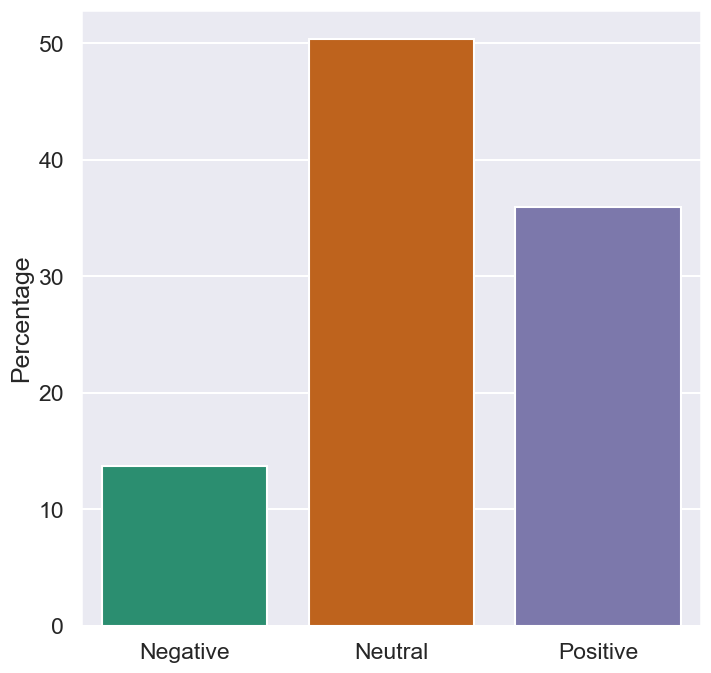

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df_title.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

## Word Distributions

In [14]:
# Tokenization
stop_words = stopwords.words('english')

def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = word_tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

## Frequency Distribution

In [15]:
pos_lines = list(df_title.headline)
tokenized_word = process_text(pos_lines)
fdist = FreqDist(tokenized_word)
fdist.most_common(10)

[('game', 5246),
 ('highlight', 2783),
 ('team', 2767),
 ('playoffs', 2570),
 ('season', 2266),
 ('warriors', 2205),
 ('player', 2108),
 ('wold', 2051),
 ('finals', 1967),
 ('celtics', 1890)]

## Stemming

In [16]:
wml = WordNetLemmatizer()
lemma_words=[]
for word in tokenized_word:
    tokens = wml.lemmatize(word)
    lemma_words.append(tokens)
    
lemma_freq = FreqDist(lemma_words)

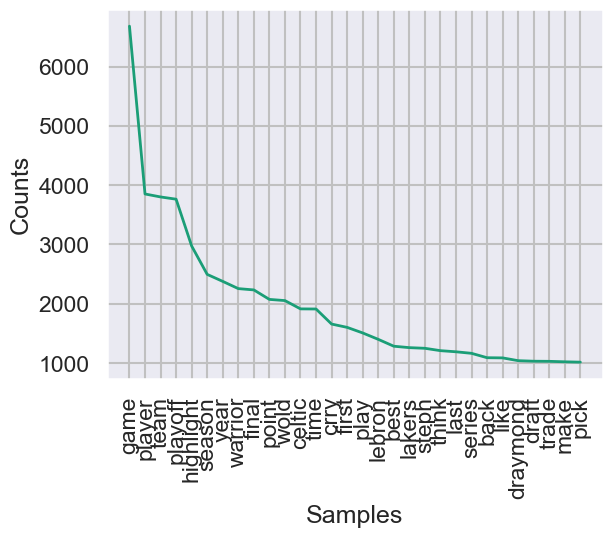

In [17]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt
lemma_freq.plot(30,cumulative=False)
plt.show()

## Wordcloud

In [18]:
def show_wordcloud(lemma_words, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate_from_text(' '.join(lemma_words))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [19]:
def word_lemmatizer(tokenized_word):
    wml = WordNetLemmatizer()
    lemma_words=[]
    for word in tokenized_word:
        tokens = wml.lemmatize(word)
        lemma_words.append(tokens)
        
    return lemma_words

In [20]:
# Positive Words
pos_lines_pos = list(df_title[df_title.label == 1].headline)
pos_tokens_pos = process_text(pos_lines_pos)
lemma_words_pos = word_lemmatizer(pos_tokens_pos)
lemma_freq_pos = nltk.FreqDist(lemma_words)
lemma_freq_pos.most_common(10)

[('game', 6682),
 ('player', 3850),
 ('team', 3800),
 ('playoff', 3762),
 ('highlight', 2972),
 ('season', 2493),
 ('year', 2375),
 ('warrior', 2253),
 ('final', 2231),
 ('point', 2071)]

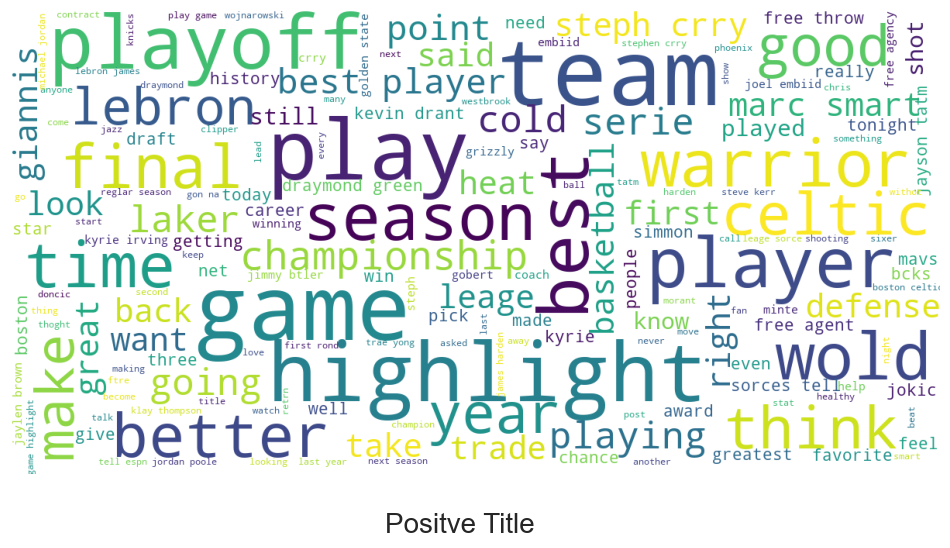

In [21]:
show_wordcloud(lemma_words_pos, title = "Positve Title")

In [22]:
# Negative Words
pos_lines_neg = list(df_title[df_title.label == -1].headline)
pos_tokens_neg = process_text(pos_lines_neg)
lemma_words_neg = word_lemmatizer(pos_tokens_neg)
lemma_freq_neg = nltk.FreqDist(lemma_words)
lemma_freq_neg.most_common(10)

[('game', 6682),
 ('player', 3850),
 ('team', 3800),
 ('playoff', 3762),
 ('highlight', 2972),
 ('season', 2493),
 ('year', 2375),
 ('warrior', 2253),
 ('final', 2231),
 ('point', 2071)]

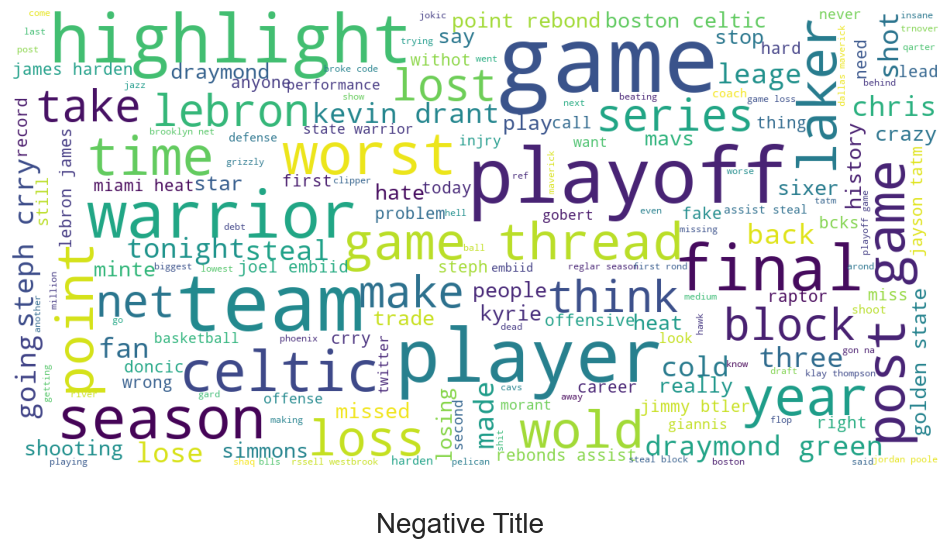

In [23]:
show_wordcloud(lemma_words_neg, title = "Negative Title")

## Topic Modeling 

In [112]:
# Tokenization in list of sentence
data = list(df_title.headline)

def tokenizer(texts):
    for text in texts:
        yield(simple_preprocess(text, deacc=True))
    
tokens_list = list(tokenizer(data))

In [97]:
#!spacy download en_core_web_sm
nlp = en_core_web_sm.load(disable = ['ner', 'parser'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [113]:
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(tokens_list, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])

['start qarter', 'poster']


In [99]:
# Create the Document-Word matrix
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10, # minimum reqd occurences of a word 
                             stop_words='english',  # remove stop words           
                             lowercase=True, # convert all words to lowercase                 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000, # max number of uniq words
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [100]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,# Number of topics
                                      max_iter=10, # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,# Random state
                                      batch_size=128,# n docs in each learning iter
                                      evaluate_every = -1,# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,# Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [102]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))
# See model parameters
print(lda_model.get_params())

Log Likelihood:  -1105105.5505205914
Perplexity:  891.5467033112412
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [104]:
# Use GridSearch to determine the best LDA model.
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)
# GridSearchCV(cv=None, error_score='raise',
#        estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
#              evaluate_every=-1, learning_decay=0.7, learning_method=None,
#              learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
#              mean_change_tol=0.001, n_components=10, n_jobs=1,
#              n_topics=None, perp_tol=0.1, random_state=None,
#              topic_word_prior=None, total_samples=1000000.0, verbose=0),
#        fit_params=None, iid=True, n_jobs=1,
#        param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
#        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#        scoring=None, verbose=0)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 learning_offset=50.0,
                                                 max_iter=5, random_state=0),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [105]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -230030.71409809758
Model Perplexity:  758.3829468788875


In [107]:
# Use LDA to look for 10 topics
n_topics = 10
learning_rate = 0.7
final_model = LatentDirichletAllocation(learning_method='online', n_components=n_topics, learning_decay=learning_rate)
final_model.fit_transform(data_vectorized)

# Print the top 10 words per topic
n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(final_model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

Topic 0: playoff series win net state look miss knick simmon pass
Topic 1: year think player history career know play star sixer thing
Topic 2: make playoff come lebron lead feel klay hit performance qestion
Topic 3: team player trade leage year rond wold today throw offer
Topic 4: say sorce tell start wiggin sign watch contract shot ask
Topic 5: warrior laker steph want championship fan time need talk conference
Topic 6: season point game coach head assist rebond piston average stat
Topic 7: game final play time basketball thread bck grizzly beat clipper
Topic 8: celtic draft pick highlight kyrie maverick jazz ball net try
Topic 9: heat shoot leave point people deal tonight score westbrook title


In [109]:
# Use NMF to look for 10 topics
n_topics = 10
nmf_model = NMF(n_components=n_topics)
nmf_model.fit_transform(data_vectorized)

# Print the top 10 words per topic
n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

Topic 0: game thread celtic series heat tonight discssion defeat post bck
Topic 1: team championship time want think win lead wold trade draft
Topic 2: player time think leage history draft wold basketball role rank
Topic 3: playoff make time series rond miss history eliminate career laker
Topic 4: season laker record westbrook win time post start miss history
Topic 5: warrior final celtic state time steph conference win beat wiggin
Topic 6: play say want basketball tonight mint think simmon time net
Topic 7: year final today draft contract championship extension time sign deal
Topic 8: point rebond assist shoot score tonight career time steal lead
Topic 9: make sorce tell say pick trade laker coach draft leage


In [71]:
# Creating a `Dictionary` with Gensim
# Create Dictionary
dictionary = corpora.Dictionary(tokens_list)
# Filter out tokens in the dictionary by their frequency.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# Create Corpus, i.e. Document-Term Matrix
corpus = [dictionary.doc2bow(text) for text in tokens_list]

In [74]:
# Optimizing coherence scores
def compute_coherence_values(dictionary, corpus, texts, limit=50, start=10, step=10):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA    
    model with respective number of topics
    """
    coherence_values = []
    model_list = []
    total_amount = limit / step
    current_amount = 0
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                    id2word=dictionary, num_topics=num_topics,
                    random_state=100, update_every=1, chunksize=500, 
                    passes=10, alpha='auto', per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts,   
                    dictionary=dictionary, coherence='c_v')  
        coherence_values.append(coherencemodel.get_coherence())
        current_amount += 1
        print("Built " + str(current_amount) + " of " + 
                    str(total_amount) + " models")
    return model_list, coherence_values

In [81]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=tokens_list, 
                                                        start=10, 
                                                        limit=200, 
                                                        step=40)

Built 1 of 5.0 models
Built 2 of 5.0 models
Built 3 of 5.0 models
Built 4 of 5.0 models
Built 5 of 5.0 models


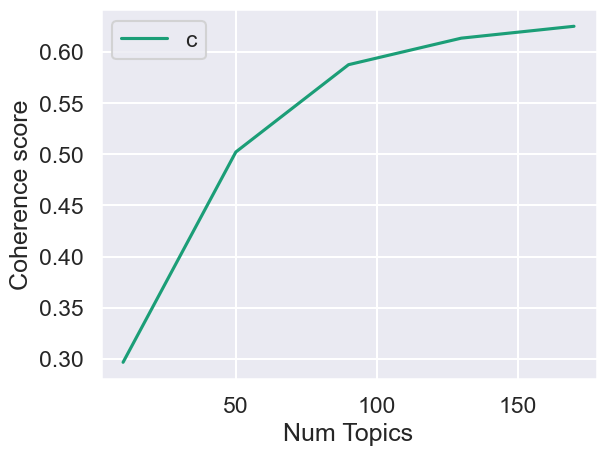

In [82]:
limit=200; start=10; step=40
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [142]:
#tokenize_word = process_text(list(df_title.headline))

# wml = WordNetLemmatizer()
# tokens_list=[]
# for word in data_lemmatized :
#     tokens = wml.lemmatize(word)
#     tokens_list.append(tokens)
    
# Create Dictionary 
# dictionary = corpora.Dictionary([flat_list])
# # Filter out tokens in the dictionary by their frequency.
# dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# # Create Corpus, i.e. Document-Term Matrix
# corpus = [dictionary.doc2bow(text) for text in [flat_list]]

# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=10, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)

In [143]:
# for index, topic in lda_model.show_topics(formatted=False, num_words= 10):
#     print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

In [144]:
# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=[data_lemmatized], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)
# #Higher the topic coherence, the topic is more human interpretable.

In [141]:
# Visualize the topics
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(final_model, data_vectorized, vectorizer, mds='lda')
vis

/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: Deprecatio

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.171689 -0.166617       1        1  12.254927
3      0.293564 -0.154719       2        1  12.169193
5     -0.067305 -0.022887       3        1  11.148063
4      0.018754  0.025309       4        1  10.845566
6     -0.262856 -0.116857       5        1   9.354942
1      0.252456 -0.198713       6        1   9.271524
0      0.060978  0.289294       7        1   9.098970
8      0.031723  0.110756       8        1   9.031374
2      0.016230  0.283821       9        1   8.602044
9     -0.171856 -0.049388      10        1   8.223397, topic_info=         Term         Freq        Total Category  logprob  loglift
648      game  5791.000000  5791.000000  Default  30.0000  30.0000
1570     team  3536.000000  3536.000000  Default  29.0000  29.0000
1105  playoff  3929.000000  3929.000000  Default  28.0000  28.0000
1375   season  2501.000000  2501.000000  Default  27.0000  27.0000
1102   player  3617.000000  3617.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
210    brnson    87.076662    87.961993  Topic10  -5.0346   2.4881
1138  predict    85.460340    86.345632  Topic10  -5.0533   2.4879
129    basket    79.340816    80.226093  Topic10  -5.1276   2.4871
1619  tonight   475.761780   865.225979  Topic10  -3.3365   1.9001
1113    point   535.686751  2002.449093  Topic10  -3.2178   1.1796

[367 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
9         9  0.995621     accord
32        7  0.997158     agency
33        2  0.994907      agent
34        4  0.992746      agree
41       10  0.988485      allow
...     ...       ...        ...
1758      9  0.228923       work
1760      3  0.995779      world
1767      2  0.358767       year
1767      6  0.641020       year
1769      5  0.985993  yesterday

[344 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 6, 5, 7, 2, 1, 9, 3, 10])